[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SeoulTechPSE/EngNm/blob/master/ch06_code.ipynb)

In [1]:
# Rendering sympy equations requires MathJax to be available within each cell output. 
# The following is a function that will make this happen for Colab.

from IPython.display import Math, HTML
def enable_sympy_in_cell():
  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', enable_sympy_in_cell)

# Chapter 6: Optimization

Creator: Robert Johansson, Updator: Kee-Youn Yoo

Updated source code listings for Numerical Python - A Practical Techniques Approach for Industry (ISBN 978-1-484205-54-9).

In this chapter we discuss using Scipy's optimization module `optimize` for nonlinear optimization
problems, and we will briefly explore using the convex optimization library `cvxopt` for linear optimization
problems with linear constraints. This library also has powerful solvers for quadratic programming problems.

The convex optimization library `cvxopt` provides solvers for linear and quadratic optimization
problems. At the time of writing, the latest version is 1.2 (2019-10-31). For more information, see the project’s web site
http://cvxopt.org. Here we use this library for constrained linear optimization.

    !conda install -c conda-forge cvxopt -y

## Importing modules

In [2]:
import numpy as np
import sympy
sympy.init_printing()
from scipy import optimize
import cvxopt

import matplotlib as mpl
import matplotlib.pyplot as plt

## Classification of optimization problems

A general optimization problem of the type considered here can be formulated as a minimization problem, $\min_x f(x)$, subject to sets of $m$ equality constraints $g(x) = 0$ and $p$ inequality constraints $h(x) \leq 0$.


Depending on the properties of the objective function $f(x)$ and the equality and inequality constraints
$g(x)$ and $h(x)$, this formulation includes a rich variety of problems.

* *univariate*(*one dimensional*) or *multivariate*(*multidimensional*) .
* *linear programming problem*. or *nonlinear programming problem*.
* *unconstrained*, or *constrained*(*equality* and *inequality* constraints require different approaches).
* *convex* or *non-convex*
* *continuous*(*smooth*) or *discontinuous*  

## Univariate optimization

As an example, consider the classic optimization problem: Minimize the area of a cylinder with unit volume. Here, suitable variables are the radius $r$ and height $h$ of the cylinder, and the objective function is 

> $f(r, h) = 2\pi r^2 + 2\pi r h$, 

subject to the equality constraint 

> $g(r, h) = \pi r^2 h -1 = 0$.

In [3]:
r, h = sympy.symbols("r, h")
Area = 2 *sympy.pi *r**2 + 2 *sympy.pi *r *h 
Volume = sympy.pi *r**2 *h

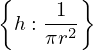

In [4]:
h_r = sympy.solve(Volume -1)[0]; h_r

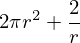

In [5]:
Area_r = Area.subs(h_r); Area_r

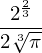

In [6]:
rsol = sympy.solve(Area_r.diff(r))[0]; rsol

In [7]:
_.evalf()

In [8]:
Area_r.diff(r, 2).subs(r, rsol)

In [9]:
Area_r.subs(r, rsol)

In [10]:
_.evalf()

---

In [11]:
def f(r):
    return 2 *np.pi *r**2 + 2 /r

In [12]:
r_min = optimize.brent(f, brack=(0.1, 4)); r_min

In [13]:
f(r_min)

---

In [14]:
optimize.minimize_scalar(f, bracket=(0.1, 4))

     fun: 5.535810445932086
    nfev: 19
     nit: 15
 success: True
       x: 0.5419260772557135

---

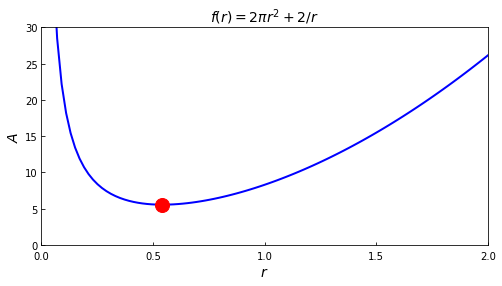

In [15]:
r = np.linspace(1.e-2, 2, 100)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'ro', markersize=14)
ax.set_title(r"$f(r) = 2\pi r^2 +2/r$", fontsize=14)
ax.set_xlabel(r"$r$", fontsize=14)
ax.set_ylabel(r"$A$", fontsize=14)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_xlim(0, 2)
ax.set_ylim(0, 30)
ax.tick_params(which='both', direction='in')
ax.tick_params(axis='x', pad=6)

#fig.tight_layout()

## Unconstrained multivariate optimization

We consider the following problem: $min_x f(x)$, where
the objective function is 

> $f(x) = (x_1 - 1)^4 + 5(x_2 - 1)^2 - 2 x_1 x_2$.

In [16]:
x1, x2 = sympy.symbols("x_1, x_2")
f_sym = (x1 -1)**4 + 5 *(x2 -1)**2 -2 *x1 *x2
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]

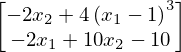

In [17]:
sympy.Matrix(fprime_sym)

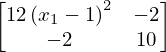

In [18]:
sympy.Matrix(fhess_sym)

In [19]:
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

In [20]:
def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

In [21]:
f = func_XY_X_Y(f_lmbda)
fprime = func_XY_X_Y(fprime_lmbda)
fhess = func_XY_X_Y(fhess_lmbda)

In Scipy, Newton conjugate gradient method is implemented in the function `optimize.fmin_ncg`. This function takes the
following arguments: a Python function for the objective function, a starting point, a Python function for
evaluating the gradient, and (optionally) a Python function for evaluating the Hessian.

In [22]:
x_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 17
         Hessian evaluations: 8


In [23]:
x_opt

array([1.88292613, 1.37658523])

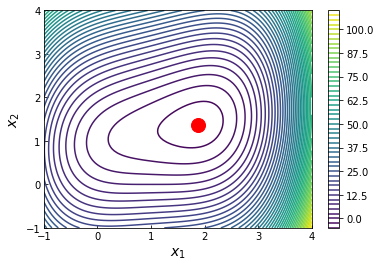

In [24]:
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)

fig, ax = plt.subplots(figsize=(6, 4))

c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'ro', markersize=14)
ax.set_xlabel(r"$x_1$", fontsize=14)
ax.set_ylabel(r"$x_2$", fontsize=14)
ax.tick_params(which='both', direction='in')
plt.colorbar(c, ax=ax);

#fig.tight_layout()

---

Methods that approximate the Hessian are known as *quasi-Newton methods*, and there are also
alternative iterative methods that completely avoid using the Hessian. Two popular methods are the BFGS
and the conjugate-gradient methods, which are implemented in `scipy` as the functions `optimize.fmin_bfgs` (the quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno) and `optimize.fmin_cg` (the conjugate-gradient method of Polak and Ribiere).

In [25]:
x_opt = optimize.fmin_bfgs(f, (0, 0), fprime=fprime); x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


array([1.88292645, 1.37658596])

In [26]:
x_opt = optimize.fmin_cg(f, (0, 0), fprime=fprime); x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


array([1.88292612, 1.37658523])

---

In [27]:
x_opt = optimize.fmin_bfgs(f, (0, 0)); x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 52
         Gradient evaluations: 13


array([1.88292644, 1.37658595])

In [28]:
x_opt = optimize.fmin_cg(f, (0, 0)); x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 72
         Gradient evaluations: 18


array([1.88292612, 1.37658522])

### Brute force search for a global minimum

The methods for multivariate optimization that we have discussed so far all converge to a local
minimum in general. For problems with many local minima, this can easily lead to a situation when the
solver easily gets stuck in a local minimum, even if a global minimum exists. Although there is no complete
and general solution to this problem, a practical approach that can partially alleviate this problem is to use a
brute force search over a coordinate grid to find a suitable starting point for an iterative solver. At least this
gives a systematic approach to find a global minimum within given coordinate ranges. In `scipy`, the function
`optimize.brute` can carry out such a systematic search.

To illustrate this method, consider the problem of minimizing the function 

> $4\sin(\pi x) + 6\sin (\pi y) +(x -1)^2 +(y -1)^2$, 

which has a large number of local minima.

In [29]:
def f(X):
    x, y = X
    return 4*np.sin(np.pi *x) +6*np.sin(np.pi *y) +(x -1)**2 +(y -1)**2

In [30]:
x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None); x_start

array([1.5, 1.5])

In [31]:
f(x_start)

In [32]:
x_opt = optimize.fmin_bfgs(f, x_start); x_opt

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7


array([1.47586906, 1.48365787])

In [33]:
f(x_opt)

---

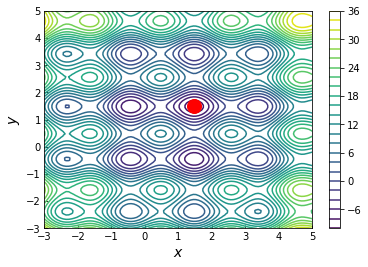

In [34]:
def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)

fig, ax = plt.subplots(figsize=(6, 4))

c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'ro', markersize=14)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
plt.colorbar(c, ax=ax)
ax.tick_params(which='both', direction='in')

#fig.tight_layout()

---

In [35]:
result = optimize.minimize(f, x_start, method='BFGS')

In [36]:
result.x

array([1.47586906, 1.48365787])

## Noninear least square problems

In general, a least square problem can be viewed as an optimization problem with the
objective function $g(\boldsymbol{\beta}) =\sum_{i=0}^{m} r_i^2(\boldsymbol{\beta})$, with the residuals $r_i(\boldsymbol{\beta}) = y_i -f(x_i, \boldsymbol{\beta})$ for a
set of $m$ obervations $(x_i, y_i)$. Here $\boldsymbol{\beta}$ is a vector with unknown parameters that specifies the function $f(x, \boldsymbol{\beta})$. If
this problem is nonlinear in the parameters $\boldsymbol{\beta}$, it is known as a nonlinear least square problem. 

In Scipy, the function `optimize.leastsq` provides a nonlinear least square solver that uses the Levenberg-Marquardt method. To illustrate how this function can be used, consider a nonlinear model on the form $f(x,\boldsymbol{\beta}) = \beta_1 + \beta_2 \exp(-\beta_3 x^2 )$ and a set of observations $(x_i, y_i)$.

Simulate the observations:

In [37]:
beta = (0.25, 0.75, 0.5)
def f(x, b0, b1, b2):
    return b0 +b1 *np.exp(-b2 *x**2)

In [38]:
xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta)
ydata = y +0.05 *np.random.randn(len(xdata))

The first step is to define a function for the residuals given the data and the model
function, which is specified in terms of the yet-to-be determined model parameters $\boldsymbol{\beta}$.

In [39]:
def g(beta):
    return ydata - f(xdata, *beta)

Next we define an initial guess for the parameter vector and let the `optimize.leastsq` function solve for
the best least square fit for the parameter vector:

In [40]:
beta_start = (1, 1, 1)
beta_opt, beta_cov = optimize.leastsq(g, beta_start)

In [41]:
beta_opt

array([0.26299756, 0.73076118, 0.52530306])

---

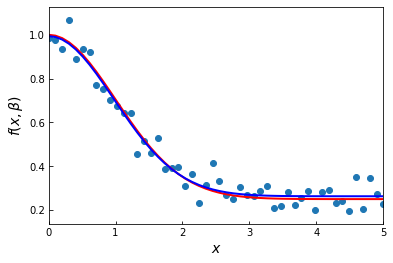

In [42]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata)
ax.plot(xdata, y, 'r', lw=2)
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2)
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=14)
ax.tick_params(which='both', direction='in')

#fig.tight_layout()

In [43]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata); beta_opt # a convenience wrapper around optimize.leastsq

array([0.26299756, 0.73076118, 0.52530306])

## Constrained optimization

A simple form of constrained optimization is the optimization where the coordinate variables
are subject to some bounds. These constraints are simple
because they only restrict the range of the coordinate without dependencies on the other variables.

This type of problem can be solved using the L-BFGS-B method in Scipy, which is a variant of the BFGS method. This solver is available through the function `optimize.fmin_l_bgfs_b` or via `optimize.minimize` with the method argument set to `'L-BFGS-B'`. To define the coordinate boundaries, the `bounds` keyword argument must be used, and its value should be a list of tuples that contain the minimum and
maximum value of each constrained variable.

Consider minimizing the objective function 

> $f(x) = (x_1 - 1)^2 +(x_2 - 1)^2$ 

subject to the constraints 

> $2 \leq x_1 \leq 3$ and $0 \leq x_2 \leq 2$ .

In [44]:
def f(X):
    x_1, x_2 = X
    return (x_1 -1)**2 +(x_2 -1)**2

In [45]:
x_opt = optimize.minimize(f, (1, 1), method='BFGS').x; x_opt

array([1., 1.])

In [46]:
bnd_x1, bnd_x2 = (2, 3), (0, 2)
x_cons_opt = optimize.minimize(f, (1, 1), method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]).x; x_cons_opt

array([2., 1.])

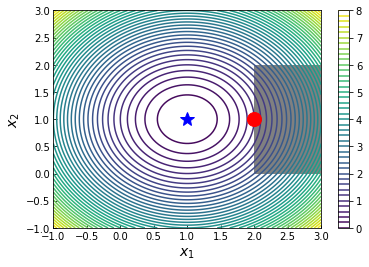

In [47]:
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)

fig, ax = plt.subplots(figsize=(6, 4))

c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'ro', markersize=14)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), 
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=14)
ax.set_ylabel(r"$x_2$", fontsize=14)
plt.colorbar(c, ax=ax)
ax.tick_params(which='both', direction='in')

#fig.tight_layout()

---

Constraints that are defined by equalities or inequalities that include more than one variable are more
complicated to deal with. However, using the Lagrange multipliers, it is possible to convert a constrained optimization problem to an
unconstrained problem by introducing additional variables.

For example, consider the optimization problem $\min_x f(x)$ subject to the equality constraint $g(x) = 0$. In an unconstrained optimization problem the gradient of $f(x)$ vanish at the optimal points, $\nabla f(x) = 0$. It can be shown that the corresponding condition for constrained problems is that the negative gradient lies in the space supported by the constraint normal,
$-\nabla f(x) = \lambda J_g^T(x)$. Here $J_g(x)$ is the Jacobian matrix of the constraint function $g(x)$ and $\lambda$ is the vector of
Lagrange multipliers (new variables). This condition is the gradient of the function $\Lambda(x, \lambda) = f(x)+ \lambda^T g(x)$,
which is known as the Lagrangian function. Therefore, if both $f(x)$ and $g(x)$ have continuous and smooth, a stationary point $(x_0, \lambda_0)$ of the $L(x, \lambda)$ corresponds to an optimum of the original constrained optimization problem, $x_0$.

Consider the problem of maximizing the volume of a rectangle with
sides of length $x_0$, $x_1$ and $x_2$, subject to the constraint that the total surface area should be unity:
$g(x) = 2x_1 x_2 + 2x_0 x_2 + 2x_1 x_0 -1 = 0$. To solve this optimization problem using Lagrange multipliers, we form
the Lagrangian $\Lambda(x) = f(x)+ \lambda g(x)$, and seek the stationary points for $\Lambda(x) = 0$.

In [48]:
x = x0, x1, x2, l = sympy.symbols("x_0, x_1, x_2, lambda")
f = x0 *x1 *x2
g = 2 *(x0 *x1 +x1 *x2 +x2 *x0) -1
L = f +l *g

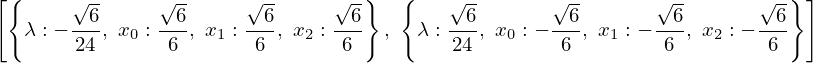

In [49]:
grad_L = [sympy.diff(L, x_) for x_ in x]
sols = sympy.solve(grad_L); sols

In [50]:
g.subs(sols[0])

In [51]:
f.subs(sols[0])

---

There exists various numerical methods of applying this approach. One example is the method known as sequential least
squares programming, abbreviated as *SLSQP*, which is available in the Scipy as the `optimize.slsqp` function
and via `optimize.minimize` with `method='SLSQP'`. The `optimize.minimize` function takes the keyword
argument constraints, which should be a list of dictionaries that each specifies a constraint. The allowed
keys (values) in this dictionary are `type` (`'eq'` or `'ineq'`), `fun` (constraint function), `jac` (Jacobian of the
constraint function).

In [52]:
def f(X):
    return -X[0] *X[1] *X[2]

def g(X):
    return 2 *(X[0] *X[1] +X[1] *X[2] +X[2] *X[0]) -1

In [53]:
constraint = dict(type='eq', fun=g)
result = optimize.minimize( f, [0.5, 1, 1.5], method='SLSQP', constraints=[constraint]); result

     fun: -0.06804136862287297
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.40824188, 0.40825127, 0.40825165])

---

To solve problems with inequality constraints, all we need to do is to set `type='ineq'` in the constraint
dictionary and provide the corresponding inequality function. To demonstrate minimization of a nonlinear
objective function with a nonlinear inequality constraint, we return to the quadratic problem considered
previously, but in this case with inequality constraint $g(x) = x_1 -1.75 -(x_0 -0.75)^4 \geq 0$.

In [54]:
def f(X):
    return (X[0] -1)**2 + (X[1] -1)**2

def g(X):
    return X[1] -1.75 -(X[0] -0.75)**4

In [55]:
x_opt = optimize.minimize(f, (0, 0), method='BFGS').x

constraints = [dict(type='ineq', fun=g)]
x_cons_opt = optimize.minimize( f, (0, 0), method='SLSQP', constraints=constraints).x

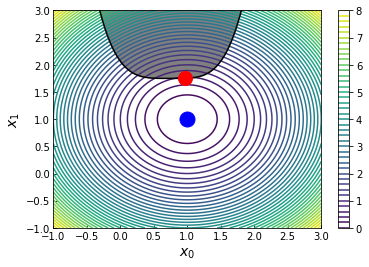

In [56]:
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)

fig, ax = plt.subplots(figsize=(6, 4))

c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'bo', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=14)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'ro', markersize=14)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=14)
ax.set_ylabel(r"$x_1$", fontsize=14)
plt.colorbar(c, ax=ax)
ax.tick_params(which='both', direction='in')

#fig.tight_layout()

For optimization problems with only inequality constraints, Scipy provides an alternative solver using
the constrained optimization by linear approximation (COBYLA) method. This solver is accessible either
through `optimize.fmin_cobyla` or `optimize.minimize` with `method='COBYLA'`. The previous example could
just as well have been solved with this solver, by replacing `method='SLSQP'` with `method='COBYLA'`.

### Linear programming

The solution to linear optimization problem must necessarily lie on a constraint boundary,
so it is sufficient to search the vertices of the intersections of the linear constraints functions. This can
be done efficiently in practice. A popular algorithm for this type of problems is known as *simplex*, which
systematically moves from one vertix to another until the optimal vertix has been reached. There are also
more recent *interior point methods* that efficiently solve linear programming problems. With these methods,
linear programming problems with thousands of variables and constraints are readily solvable.

Linear programming problems are typically written in the so-called standard form: 

> $\min_\mathbf{x} \mathbf{c}^T \mathbf{x}$ 

where

> $\mathbf{A}\mathbf{x} \leq \mathbf{b}$ and $\mathbf{x} \geq \mathbf{0}$. 

Here $\mathbf{c}$ and $\mathbf{x}$ are vectors of length $n$, and $\mathbf{A}$ is a $m \times n$ matrix and $\mathbf{b}$ a $m$-vector. 

Consider the problem of minimizing the function 

> $f(x) = -x_0 + 2x_1 -3x_2$, 

subject to the three inequality constraints 

>$x_0 +x_1 \leq 1$, $-x_0 + 3x_1 \leq 2$, and $-x_1 +x_2 \leq 3$. 

On the standard form,

>$\mathbf{c} = \begin{pmatrix}
-1\\ 
2\\ 
-3
\end{pmatrix}, \:\: 
\mathbf{A} = \begin{pmatrix}
1 & 1 & 0\\ 
 -1& 3 & 0\\ 
0 & -1 & 1
\end{pmatrix}\:\:
\mathbf{b} = \begin{pmatrix}
1\\ 
2\\
3
\end{pmatrix}.$

To solve this problem, here we use the `cvxopt` library, which provides the linear programming solver
with the `cvxopt.solvers.lp` function.

In [57]:
c = np.array([-1.0, 2.0, -3.0])
A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])
b = np.array([1.0, 2.0, 3.0])

In [58]:
c_ = cvxopt.matrix(c)
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)

In [59]:
sol = cvxopt.solvers.lp(c_, A_, b_); sol

Optimal solution found.


{'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <3x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 0.0,
 'relative gap': 0.0,
 'primal objective': -10.0,
 'dual objective': -10.0,
 'primal infeasibility': 0.0,
 'primal slack': -0.0,
 'dual slack': 2.7755575615628914e-17,
 'dual infeasibility': 2.967195843610875e-17,
 'residual as primal infeasibility certificate': None,
 'residual as dual infeasibility certificate': None,
 'iterations': 0}

In [60]:
x = np.array(sol['x']); x

array([[0.25],
       [0.75],
       [3.75]])

In [61]:
sol['primal objective']

### Quadratic programming

Quadratic programming problems are typically written in the so-called standard form:

>$\min_\mathbf{x}\frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} +\mathbf{p}^T\mathbf{x}$, 

subject to 

>$\mathbf{G}\mathbf{x} \leq \mathbf{h}$ and $\mathbf{A}\mathbf{x} = \mathbf{b}$.

Quadratic programs can be solved via the `cvxopt.solvers.qp()` function. As an example, consider the following QP: 

>$\min_{x_1, x_2} 2x_1^2 +x_2^2 +x_1 x_2 + x_1 +x_2$, 

subject to 

>$x_1 \geq 0$, $x_2 \geq 0$, and $x_1 +x_2 =1$. 

In [62]:
Q = 2*cvxopt.matrix([[2, 0.5], [0.5, 1]])
p = cvxopt.matrix([1.0, 1.0])
G = cvxopt.matrix([[-1.0, 0.0], [0.0,-1.0]])
h = cvxopt.matrix([0.0, 0.0])
A = cvxopt.matrix([1.0, 1.0], (1, 2))
b = cvxopt.matrix(1.0)
sol = cvxopt.solvers.qp(Q, p, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  3e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  6e-17  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  2e-16  5e-08
Optimal solution found.


In [63]:
x = np.array(sol['x']); x

array([[0.2500001],
       [0.7499999]])

In [64]:
sol['primal objective']

## Versions

In [65]:
from scipy import __version__
print("numpy: ", np.__version__)
print("sympy: ", sympy.__version__)
print("scipy: ", __version__)
print("matplotlib: ", mpl.__version__)
print("cvxopt: ", cvxopt.__version__)

scipy:  1.3.1
sympy:  1.4
matplotlib:  3.1.1
cvxopt:  1.2.0
